# UES Algorithm

This Notebook focuses on the re-implementation of the UES query plan optimization algorithm.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import collections
import json
import pathlib
import warnings

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

from transform import db, mosp, ues, job, util
from postgres import explain

In [3]:
df_orig = pd.read_csv("workloads/job-ues-results-base.csv")
df_orig

,label,query,query_result,query_rt_total,run
0,1a,select count(*) from movie_companies as mc j...,"[{""Plan"": {""Node Type"": ""Aggregate"", ""Strategy...",3.210727,1
1,1b,select count(*) from movie_info_idx as mi_idx...,"[{""Plan"": {""Node Type"": ""Aggregate"", ""Strategy...",0.585980,1
2,1c,select count(*) from movie_companies as mc j...,"[{""Plan"": {""Node Type"": ""Aggregate"", ""Strategy...",0.708080,1
3,1d,select count(*) from movie_info_idx as mi_idx...,"[{""Plan"": {""Node Type"": ""Aggregate"", ""Strategy...",0.646869,1
4,2a,select count(*) from movie_keyword as mk joi...,"[{""Plan"": {""Node Type"": ""Aggregate"", ""Strategy...",2.176834,1
...,...,...,...,...,...
560,32a,select count(*) from movie_link as ml join l...,"[{""Plan"": {""Node Type"": ""Aggregate"", ""Strategy...",0.012331,5
561,32b,select count(*) from movie_link as ml join l...,"[{""Plan"": {""Node Type"": ""Aggregate"", ""Strategy...",0.647438,5
562,33a,select count(*) from movie_link as ml join l...,"[{""Plan"": {""Node Type"": ""Aggregate"", ""Strategy...",1.598524,5
563,33b,select count(*) from movie_link as ml join l...,"[{""Plan"": {""Node Type"": ""Aggregate"", ""Strategy...",0.683531,5


In [4]:
df_rebuild = pd.read_csv("workloads/job-ues-results-rebuild.csv")
df_rebuild

,label,query,optimization_time,query_result,query_rt_total,run
0,3c,SELECT COUNT(*) FROM movie_info AS mi JOIN tit...,1.247186,"[{""Plan"": {""Node Type"": ""Aggregate"", ""Strategy...",7.739981,1
1,1d,SELECT COUNT(*) FROM movie_info_idx AS mi_idx ...,0.289792,"[{""Plan"": {""Node Type"": ""Aggregate"", ""Strategy...",0.629498,1
2,15d,SELECT COUNT(*) FROM movie_info AS mi JOIN inf...,1.273317,"[{""Plan"": {""Node Type"": ""Aggregate"", ""Strategy...",2.192735,1
3,28c,SELECT COUNT(*) FROM comp_cast_type AS cct1 JO...,0.179784,"[{""Plan"": {""Node Type"": ""Aggregate"", ""Strategy...",2.810289,1
4,33a,SELECT COUNT(*) FROM movie_link AS ml JOIN lin...,0.450182,"[{""Plan"": {""Node Type"": ""Aggregate"", ""Strategy...",3.351613,1
...,...,...,...,...,...,...
560,33b,SELECT COUNT(*) FROM movie_link AS ml JOIN lin...,0.010289,"[{""Plan"": {""Node Type"": ""Aggregate"", ""Strategy...",0.623646,5
561,18b,SELECT COUNT(*) FROM movie_info AS mi JOIN inf...,0.007727,"[{""Plan"": {""Node Type"": ""Aggregate"", ""Strategy...",4.258175,5
562,3a,SELECT COUNT(*) FROM movie_info AS mi JOIN tit...,0.002674,"[{""Plan"": {""Node Type"": ""Aggregate"", ""Strategy...",2.614265,5
563,14b,SELECT COUNT(*) FROM movie_info_idx AS mi_idx ...,0.008680,"[{""Plan"": {""Node Type"": ""Aggregate"", ""Strategy...",1.936654,5


In [5]:
df_orig.groupby("run").query_rt_total.sum(), df_rebuild.groupby("run").query_rt_total.sum()

(run
 1    295.824442
 2    281.237423
 3    278.699711
 4    274.818035
 5    275.428677
 Name: query_rt_total, dtype: float64,
 run
 1    394.387245
 2    384.149360
 3    386.890772
 4    384.875572
 5    390.185424
 Name: query_rt_total, dtype: float64)

In [6]:
max_orig_rts = df_orig.groupby("label").query_rt_total.max()
max_rebuild_rts = df_rebuild.groupby("label").query_rt_total.max()
max_rt_diffs = max_rebuild_rts - max_orig_rts
max_rt_diffs.describe()

count    113.000000
mean       0.876315
std        2.367991
min       -5.791046
25%       -0.191095
50%        0.038422
75%        2.270259
max        6.708770
Name: query_rt_total, dtype: float64

In [7]:
min_orig_rts = df_orig.groupby("label").query_rt_total.min()
min_rebuild_rts = df_rebuild.groupby("label").query_rt_total.min()
min_rt_diffs = min_rebuild_rts - min_orig_rts
min_rt_diffs.describe()

count    113.000000
mean       0.939896
std        1.905471
min       -3.067007
25%       -0.131694
50%        0.048248
75%        2.233774
max        5.909474
Name: query_rt_total, dtype: float64

<AxesSubplot:>

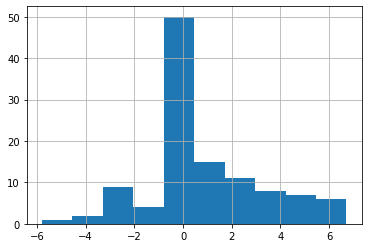

In [8]:
max_rt_diffs.hist()

In [9]:
worst_label = min_rt_diffs[min_rt_diffs == min_rt_diffs.max()].index.values[0]
max_rt_diffs[max_rt_diffs == max_rt_diffs.max()]

label
31a    6.70877
Name: query_rt_total, dtype: float64

In [10]:
query_orig = mosp.MospQuery.parse(df_orig.loc[df_orig.label == worst_label].iloc[0].query)
result_orig = json.loads(df_orig.loc[df_orig.label == worst_label].iloc[0].query_result)
query_orig

SELECT COUNT(*) FROM complete_cast AS cc JOIN comp_cast_type AS cct1 ON cct1.kind = 'cast' AND cct1.id = cc.subject_id JOIN comp_cast_type AS cct2 ON cct2.kind = 'complete+verified' AND cct2.id = cc.status_id JOIN title AS t ON t.title = 'shrek 2' AND t.production_year BETWEEN 2000 AND 2010 AND t.id = cc.movie_id JOIN movie_companies AS mc ON mc.movie_id = cc.movie_id JOIN company_name AS cn ON cn.country_code = '[us]' AND cn.id = mc.company_id JOIN (SELECT movie_id FROM movie_keyword AS mk JOIN keyword AS k ON k.keyword = 'computer-animation' AND k.id = mk.keyword_id) AS t_mk ON t_mk.movie_id = mc.movie_id JOIN cast_info AS ci ON ci.movie_id = t_mk.movie_id AND ci.note IN ('(voice)', '(voice) (uncredited)', '(voice: english version)') JOIN char_name AS chn ON chn.name = 'queen' AND chn.id = ci.person_role_id JOIN role_type AS rt ON rt.role = 'actress' AND rt.id = ci.role_id JOIN aka_name AS an ON an.person_id = ci.person_id JOIN name AS n ON n.gender = 'f' AND n.name LIKE '%an%' AND n

In [11]:
query_rebuild = mosp.MospQuery.parse(df_rebuild.loc[df_rebuild.label == worst_label].iloc[0].query)
result_rebuild = json.loads(df_rebuild.loc[df_rebuild.label == worst_label].iloc[0].query_result)
query_rebuild

SELECT COUNT(*) FROM comp_cast_type AS cct1 JOIN (SELECT cc.status_id AS cc_status_id, cc.movie_id AS cc_movie_id, cc.subject_id AS cc_subject_id, t.id AS t_id FROM complete_cast AS cc JOIN title AS t ON t.id = cc.movie_id AND t.title = 'Shrek 2' AND t.production_year BETWEEN 2000 AND 2010) AS cc_t ON cct1.id = cc_t.cc_subject_id AND cct1.kind = 'cast' JOIN comp_cast_type AS cct2 ON cct2.id = cc_t.cc_status_id AND cct2.kind = 'complete+verified' JOIN movie_companies AS mc ON cc_t.t_id = mc.movie_id AND mc.movie_id = cc_t.cc_movie_id JOIN company_name AS cn ON cn.id = mc.company_id AND cn.country_code = '[us]' JOIN (SELECT k.id AS k_id, mk.movie_id AS mk_movie_id, mk.keyword_id AS mk_keyword_id FROM movie_keyword AS mk JOIN keyword AS k ON k.id = mk.keyword_id AND k.keyword = 'computer-animation') AS k_mk ON cc_t.t_id = k_mk.mk_movie_id AND mc.movie_id = k_mk.mk_movie_id AND k_mk.mk_movie_id = cc_t.cc_movie_id JOIN cast_info AS ci ON cc_t.t_id = ci.movie_id AND mc.movie_id = ci.movie_id

In [12]:
raw_query = job.load_query(worst_label)
raw_query

SELECT COUNT(*) FROM aka_name AS an, complete_cast AS cc, comp_cast_type AS cct1, comp_cast_type AS cct2, char_name AS chn, cast_info AS ci, company_name AS cn, info_type AS it, info_type AS it3, keyword AS k, movie_companies AS mc, movie_info AS mi, movie_keyword AS mk, name AS n, person_info AS pi, role_type AS rt, title AS t WHERE cct1.kind = 'cast' AND cct2.kind = 'complete+verified' AND chn.name = 'Queen' AND ci.note IN ('(voice)', '(voice) (uncredited)', '(voice: English version)') AND cn.country_code = '[us]' AND it.info = 'release dates' AND it3.info = 'trivia' AND k.keyword = 'computer-animation' AND mi.info IS NOT NULL AND (mi.info LIKE 'Japan:%200%' OR mi.info LIKE 'USA:%200%') AND n.gender = 'f' AND n.name LIKE '%An%' AND rt.role = 'actress' AND t.title = 'Shrek 2' AND t.production_year BETWEEN 2000 AND 2010 AND t.id = mi.movie_id AND t.id = mc.movie_id AND t.id = ci.movie_id AND t.id = mk.movie_id AND t.id = cc.movie_id AND mc.movie_id = ci.movie_id AND mc.movie_id = mi.mo

In [13]:
plan_orig = explain.parse_explain_analyze(query_orig, result_orig)
plan_orig.join_path()

/home/strix/Projekte/DiplomArbeit-QueryOpt/ues/postgres/explain.py:491: UserWarning: Unknown node type: Hash
  warnings.warn("Unknown node type: {}".format(node_type))
/home/strix/Projekte/DiplomArbeit-QueryOpt/ues/postgres/explain.py:491: UserWarning: Unknown node type: Sort
  warnings.warn("Unknown node type: {}".format(node_type))
/home/strix/Projekte/DiplomArbeit-QueryOpt/ues/postgres/explain.py:491: UserWarning: Unknown node type: Gather
  warnings.warn("Unknown node type: {}".format(node_type))
/home/strix/Projekte/DiplomArbeit-QueryOpt/ues/postgres/explain.py:491: UserWarning: Unknown node type: Aggregate
  warnings.warn("Unknown node type: {}".format(node_type))


'complete_cast cc ⋈ comp_cast_type cct1 ⋈ comp_cast_type cct2 ⋈ title t ⋈ movie_companies mc ⋈ company_name cn ⋈ (movie_keyword mk ⋈ keyword k) ⋈ cast_info ci ⋈ char_name chn ⋈ role_type rt ⋈ aka_name an ⋈ name n ⋈ (person_info pi ⋈ info_type it3) ⋈ movie_info mi ⋈ info_type it'

In [14]:
plan_rebuild = explain.parse_explain_analyze(query_rebuild, result_rebuild)
plan_rebuild.join_path()

'(complete_cast cc ⋈ title t) ⋈ comp_cast_type cct1 ⋈ comp_cast_type cct2 ⋈ movie_companies mc ⋈ company_name cn ⋈ (movie_keyword mk ⋈ keyword k) ⋈ cast_info ci ⋈ char_name chn ⋈ role_type rt ⋈ name n ⋈ aka_name an ⋈ (person_info pi ⋈ info_type it3) ⋈ movie_info mi ⋈ info_type it'

.. Bounds for candidate aka_name AS an :: Filter: 1312273 | PKs: [6313503]
.. Bounds for candidate complete_cast AS cc :: Filter: 135086 | PKs: [6]
.. Bounds for candidate comp_cast_type AS cct1 :: Filter: 1 | PKs: []
.. Bounds for candidate comp_cast_type AS cct2 :: Filter: 1 | PKs: []
.. Bounds for candidate cast_info AS ci :: Filter: 1518088 | PKs: [2136568, 7254, 1382004036, 20656819]
.. Bounds for candidate movie_companies AS mc :: Filter: 4958296 | PKs: [9935501142, 780]
.. Bounds for candidate movie_info AS mi :: Filter: 446556 | PKs: [5474234, 12144]
.. Bounds for candidate movie_keyword AS mk :: Filter: 7480087 | PKs: [88123, 3420]
.. Bounds for candidate person_info AS pi :: Filter: 4130207 | PKs: [906344, 131277321]
Selected first table: comp_cast_type AS cct1 with PK/FK joins []
.. Base estimates: {comp_cast_type AS cct1: 1, comp_cast_type AS cct2: 1, char_name AS chn: 1, cast_info AS ci: 1518088, company_name AS cn: 139522, info_type AS it: 1, info_type AS it3: 1, keyword 

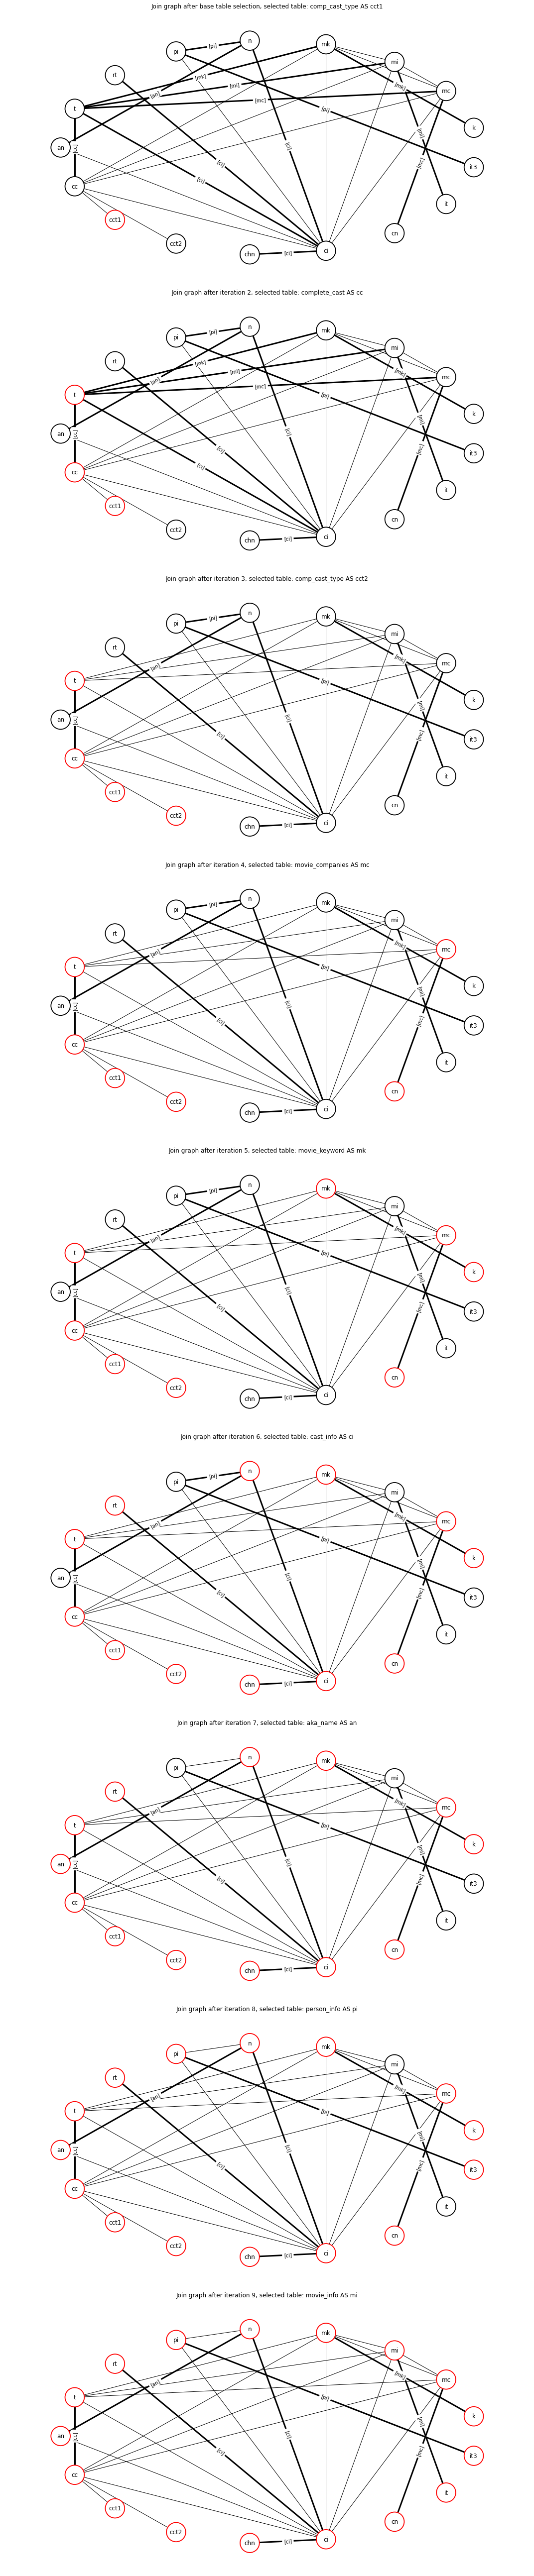

In [15]:
reopt_query = ues.optimize_query(raw_query, visualize=True, visualize_args={"figsize": (15, 8)}, trace=True)

In [38]:
reopt_query

SELECT COUNT(*) FROM comp_cast_type AS cct1 JOIN (SELECT t.id AS t_id, cc.subject_id AS cc_subject_id, cc.movie_id AS cc_movie_id, cc.status_id AS cc_status_id FROM complete_cast AS cc JOIN title AS t ON t.id = cc.movie_id AND t.title = 'Shrek 2' AND t.production_year BETWEEN 2000 AND 2010) AS cc_t ON cct1.id = cc_t.cc_subject_id AND cct1.kind = 'cast' JOIN comp_cast_type AS cct2 ON cct2.id = cc_t.cc_status_id AND cct2.kind = 'complete+verified' JOIN movie_companies AS mc ON cc_t.t_id = mc.movie_id AND mc.movie_id = cc_t.cc_movie_id JOIN company_name AS cn ON cn.id = mc.company_id AND cn.country_code = '[us]' JOIN (SELECT k.id AS k_id, mk.movie_id AS mk_movie_id, mk.keyword_id AS mk_keyword_id FROM movie_keyword AS mk JOIN keyword AS k ON k.id = mk.keyword_id AND k.keyword = 'computer-animation') AS k_mk ON cc_t.t_id = k_mk.mk_movie_id AND mc.movie_id = k_mk.mk_movie_id AND k_mk.mk_movie_id = cc_t.cc_movie_id JOIN cast_info AS ci ON cc_t.t_id = ci.movie_id AND mc.movie_id = ci.movie_id